<a href="https://colab.research.google.com/github/Edwin10151/Edwin10151/blob/main/audio_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install IPython

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display 

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract = True,
      cache_dir = '.', cache_subdir = 'data')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print(commands)

['right' 'left' 'up' 'stop' 'yes' 'no' 'down' 'go']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(num_samples)
print(len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print(filenames[0])

8000
1000
tf.Tensor(b'data/mini_speech_commands/down/8830e17f_nohash_2.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400:7200]
test_files = filenames[-800:]

print(len(train_files))
print(len(val_files))
print(len(test_files))

6400
800
800


In [ ]:
def decodeaudio(audio_binary):
  audio, _= tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis = -1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]


In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decodeaudio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls = AUTOTUNE)


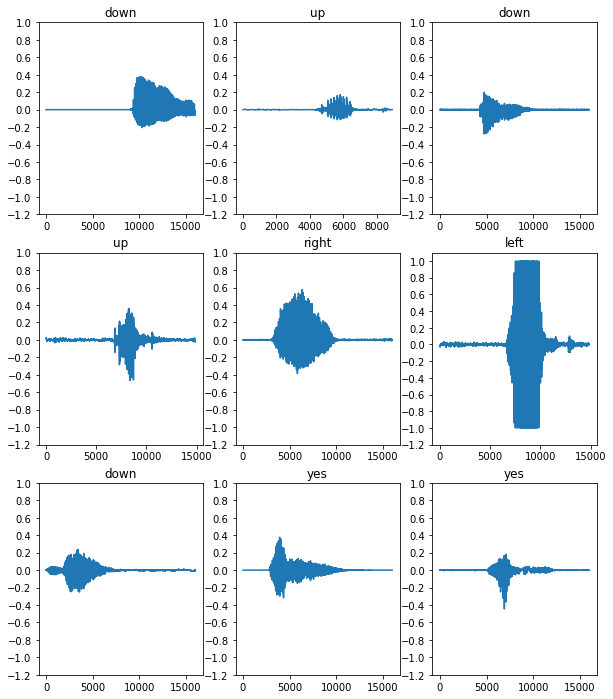

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize = (10,12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i //cols
  c = i% cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype = tf.float32)
  
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding],0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length = 255, frame_step = 128)
  spectrogram = tf.abs(spectrogram)

  return spectrogram




In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)


print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate = 16000))



Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


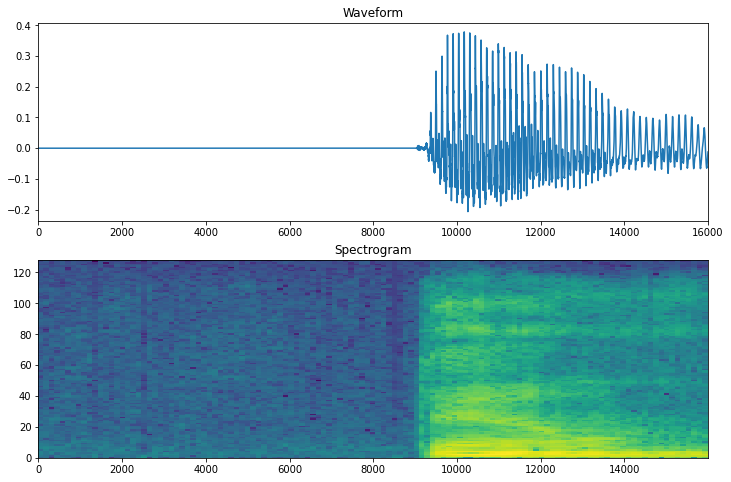

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()


In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


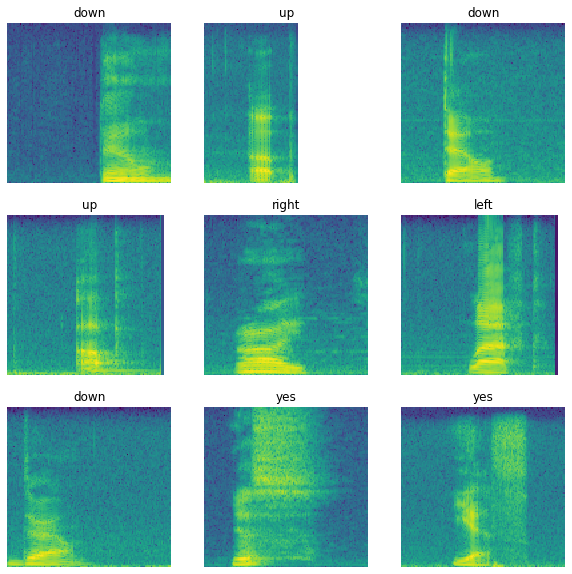

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls= AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id, num_parallel_calls = AUTOTUNE
  )
  return output_ds


In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
'''
For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the 
audio files into spectrogram images. The model also has the following additional preprocessing layers:

A Resizing layer to downsample the input to enable the model to train faster.
A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order 
to compute aggregate statistics (i.e. mean and standard deviation).
'''

"\nFor the model, you'll use a simple convolutional neural network (CNN), since you have transformed the \naudio files into spectrogram images. The model also has the following additional preprocessing layers:\n\nA Resizing layer to downsample the input to enable the model to train faster.\nA Normalization layer to normalize each pixel in the image based on its mean and standard deviation.\nFor the Normalization layer, its adapt method would first need to be called on the training data in order \nto compute aggregate statistics (i.e. mean and standard deviation).\n"

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
                           layers.Input(shape = input_shape),
                           preprocessing.Resizing(32, 32),
                           norm_layer,
                           layers.Conv2D(32, 3, activation = 'relu'),
                           layers.Conv2D(64, 3, activation = 'relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.25),
                           layers.Flatten(),
                           layers.Dense(128, activation = 'relu'),
                           layers.Dropout(0.5),
                           layers.Dense(num_labels),])
model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, validation_data = val_ds, epochs = EPOCHS, 
    callbacks = tf.keras.callbacks.EarlyStopping(verbose= 1, patience = 2),)

Epoch 1/10
100/100 [==============================] - 45s 139ms/step - loss: 1.7592 - accuracy: 0.3572 - val_loss: 1.3106 - val_accuracy: 0.5775
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.2294 - accuracy: 0.5614 - val_loss: 0.9553 - val_accuracy: 0.6938
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.9556 - accuracy: 0.6603 - val_loss: 0.7406 - val_accuracy: 0.7525
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.7784 - accuracy: 0.7267 - val_loss: 0.6497 - val_accuracy: 0.7738
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6454 - accuracy: 0.7705 - val_loss: 0.6016 - val_accuracy: 0.7775
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.5676 - accuracy: 0.7969 - val_loss: 0.5321 - val_accuracy: 0.8075
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.4892 - accuracy: 0.8319 - val_loss: 0.5200 - val_accuracy: 0.8125
Epo

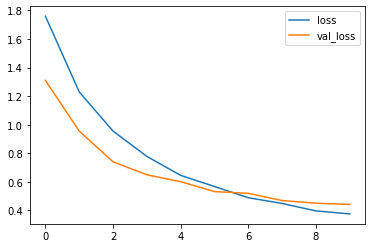

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
'''
Evaluate test set performance
'''

'\nEvaluate test set performance\n'

In [ ]:
test_audio = []
test_labels = []
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred ==  y_true) / len(y_true)
print(f'Test set accuracy:{test_acc:.0%}')


Test set accuracy:85%


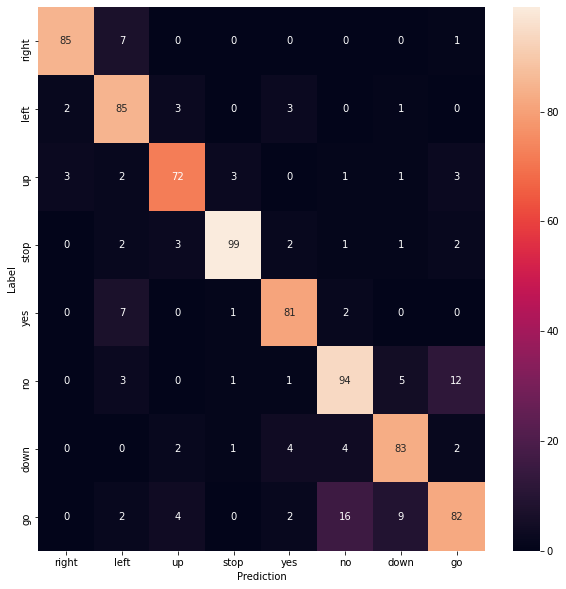

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(confusion_mtx, xticklabels = commands, yticklabels = commands,
            annot = True, fmt = 'g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


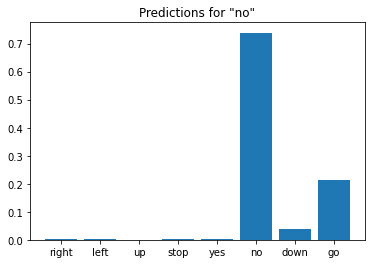

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()